In [1]:
from aicsimageio import AICSImage
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter
from skimage import exposure
from plantseg.predictions.functional.predictions import unet_predictions
from plantseg.segmentation.functional.segmentation import *
import numpy as np
from tqdm import tqdm
from skimage.measure import regionprops, regionprops_table
from sklearn.model_selection import ParameterGrid
from skimage.segmentation import relabel_sequential
from cellpose import core, utils, io, models, metrics, plot
from cellpose.plot import *
from ome_types.model import OME, Image, Pixels, Channel
from scipy import stats
import matplotlib.pyplot as plt

/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/cupy/_environment.py:445: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


## Image Loading

In [2]:
INPUT = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi"

OUTPUT_DIR = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488_res"

In [3]:
SCENE_IDX=1
CH_IDX=1
SUBSAMPLE=10
TAIL=5

In [4]:
img = AICSImage(INPUT)
img.set_scene(SCENE_IDX)
img_dask = img.get_image_dask_data("CYX")
img = img_dask[CH_IDX,:,:].compute()

### Normalization

In [5]:
img_subsampled = img[::SUBSAMPLE,::SUBSAMPLE]
pl, pu = np.percentile(np.ravel(img_subsampled[img_subsampled >= 1200]), (TAIL, 100-TAIL))

if not isinstance(pl, (int,float)):
    pl = pl.compute()
if not isinstance(pu, (int,float)):
    pu = pu.compute()

print("Percentiles: ({:.2f},{:.2f})".format(pl,pu))

Percentiles: (1428.00,10203.00)


In [6]:
print("Rescaling image intensity...")
frame_rescaled = exposure.rescale_intensity(img, in_range=(pl, pu),out_range=(0,1))

Rescaling image intensity...


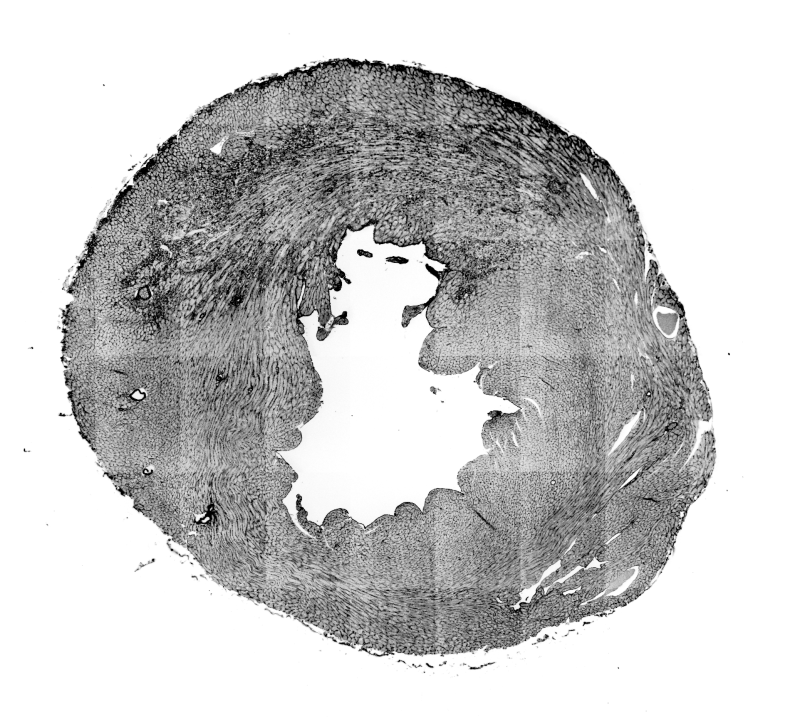

In [7]:
fig, axs = plt.subplots(1,1,figsize=(10,10))
axs.imshow(frame_rescaled[::SUBSAMPLE,::SUBSAMPLE],cmap="Greys")
axs.set_axis_off()

## Segmentation

In [8]:
pred = unet_predictions(frame_rescaled[np.newaxis,:,:],"lightsheet_2D_unet_root_ds1x",patch=[1,2048,2048])

2024-04-08 11:27:14,147 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 64/64 [00:31<00:00,  2.04it/s]


In [9]:
pred_masked = pred[0,:,:]
pred_masked[img < 1200] = 0

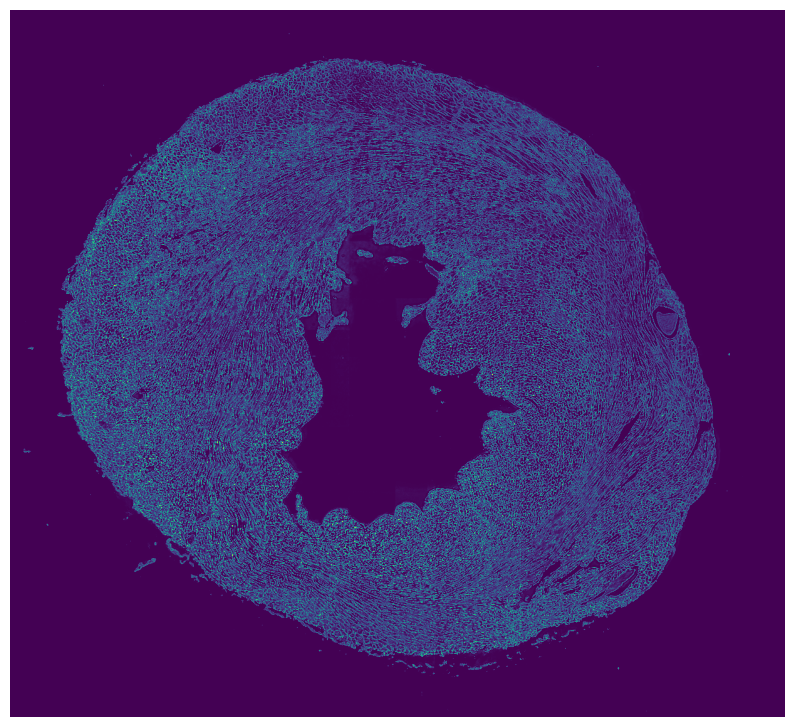

In [17]:
fig, axs = plt.subplots(1,1,figsize=(10,10))
axs.imshow(pred_masked[::SUBSAMPLE,::SUBSAMPLE],cmap="viridis",vmin=0,vmax=1)
axs.set_axis_off()